# Spatial Data Baselines and Squidpy


In this notebook we will go through a baseline analysis (simple methods) for a spatial data analysis. We will use a standard cell type histogram-based tools and some neighborhood enrichement analysis from a reowned package [`squidpy`](https://squidpy.readthedocs.io/en/stable/index.html).

Before continuing, be sure that your colab uses a GPU backend.

Let's start with installation of required packages:

In [ ]:
!pip install numba
!pip install -v --no-cache-dir numcodecs==0.15.1
!pip install anndata
!pip install squidpy

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Obtaining dependency information for numcodecs==0.15.1 from https://files.pythonhosted.org/packages/a6/a8/908a226632ffabf19caf8c99f1b2898f2f22aac02795a6fe9d018fd6d9dd/numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of distributed to determine which versio

Now - upload the `train_adata.h5ad` file from [here](https://drive.google.com/drive/folders/1pLrAb0Hy6kudQ-BHZ1w_afq18Z9eu_RE?usp=share_link) to your colab and set `TRAIN_ANNDATA_PATH` appropriately:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_ANNDATA_PATH = '/content/drive/MyDrive/data/train_adata.h5ad'

Mounted at /content/drive


## [Anndata](https://anndata.readthedocs.io/en/stable/) loading

The data is provided in a form of [`anndata`](https://anndata.readthedocs.io/en/stable/) file. Anndata is an extension of pandas.DataFrame, so that one can store additional information about rows and columns of a dataframe.

In [ ]:
import anndata

train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

As we may see object contains 253433 cells with 40 markers expressions. `obs` contains a dataframe with information about cells, including `Pos_X`, `Pos_Y` - position of a cell within a specific `image`. An important information is also included in a columns `celltypes` containing information about a phenotype of a given cell. Information about markers is stored in a `var` field. Actual marker expressions are stored in `layers`.

Spend some time reading the documentation and getting familiar with the format.

Try to:
- compute the counts of each cell type,
- compute the counts of each cell type for a given image (hint: `anndata` supports subsetting like a normal dataframe),
- plot a histogram expression of a tumor `Ecad` marker for `tumor` cells vs the other,
- check how many images are in the study.

In [ ]:
print(f"Number of cells: {train_anndata.n_obs}")
print(f"Number of genes: {train_anndata.n_vars}")
print(f"Count of each cell type: {train_anndata.obs['celltypes'].value_counts()}")

image_id = train_anndata.obs['image'][0]
print(f"Count of each cell type for {image_id}:")
subset_anndata = train_anndata[train_anndata.obs['image'] == image_id]
image_cell_type_counts = subset_anndata.obs['celltypes'].value_counts()
print(image_cell_type_counts)

Number of cells: 253433
Number of genes: 40
Count of each cell type: celltypes
Tumor         138266
CD8            22722
Mural          20537
MacCD163       15288
CD4            13238
plasma          7872
Neutrophil      7386
BnT             6493
Treg            6381
DC              4921
HLADR           3925
B               3731
pDC             1561
NK              1112
Name: count, dtype: int64
Count of each cell type for IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff:
celltypes
Mural         170
MacCD163      111
HLADR          89
Tumor          54
CD4            21
CD8            14
DC             12
NK              9
Neutrophil      4
Treg            3
Name: count, dtype: int64


<ipython-input-73-9c292adcb85e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = train_anndata.obs['image'][0]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

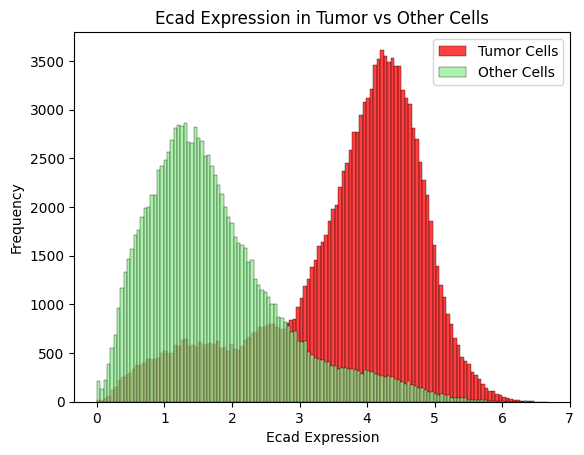

In [ ]:
tumor_cells = train_anndata[train_anndata.obs['celltypes'] == 'Tumor']
other_cells = train_anndata[train_anndata.obs['celltypes'] != 'Tumor']

# Get ECAD by 34 column
ecad_index = int(train_anndata.var.index[train_anndata.var['marker'] == 'Ecad'].tolist()[0])
sns.histplot(tumor_cells.layers['exprs'][:, ecad_index].flatten(), label='Tumor Cells', color='red', kde=False)
sns.histplot(other_cells.layers['exprs'][:, ecad_index].flatten(), label='Other Cells', color='lightgreen', kde=False)

plt.xlabel('Ecad Expression')
plt.ylabel('Frequency')
plt.title('Ecad Expression in Tumor vs Other Cells')
plt.legend()
plt.show()

In [ ]:
num_images = train_anndata.obs['image'].nunique()
print(f"Number of images in the study: {num_images}")

Number of images in the study: 132


As you probably noticed from a histogram of `Ecad` - the distribution of markers is super heavy tailed. Because of that - let's introduce a new layer with an expression transformed using a popular `numpy.arcsinh(x / 5.)` transform:

In [ ]:
import numpy as np


train_anndata.layers['exprs_as'] = np.arcsinh(train_anndata.layers['exprs'] / 5.)

## Celltype count based representation of images.

Before jumping into more advanced methods, let's try some basics.

In this exercise your task is to:
1. compute an `image_to_celltype` dataframe, with index being an `image` and columns containing `celltypes` counts (hint: [`pandas.pivot_table`](https://pandas.pydata.org//docs/reference/api/pandas.pivot_table.html) might be useful),
2. compute an `image_to_celltype_n` dataframe, that contains the normalized counts from `image_to_celltype` (counts in each image should sum up to `1`),

In [ ]:
import pandas as pd

image_to_celltype = pd.pivot_table(
    train_anndata.obs,
    index='image',
    columns='celltypes',
    aggfunc='size',
    fill_value=0
)

# Normalize counts
image_to_celltype_n = image_to_celltype.div(image_to_celltype.sum(axis=1), axis=0)

<ipython-input-79-0bfef57fe459>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  image_to_celltype = pd.pivot_table(


In [ ]:
image_to_celltype_n.head()

celltypes,B,BnT,CD4,CD8,DC,HLADR,MacCD163,Mural,NK,Neutrophil,Treg,Tumor,pDC,plasma
image,,,,,,,,,,,,,,
IMMUcan_2022_WFLOW_10061074-SPECT-VAR-TIS-01-IMC-01_001.tiff,0.003298,0.000000,0.042045,0.181369,0.015664,0.007420,0.124897,0.023495,0.011954,0.110058,0.004122,0.419209,0.010305,0.046167
IMMUcan_2022_WFLOW_10063152-SPECT-VAR-TIS-01-IMC-01_002.tiff,0.003793,0.000000,0.059418,0.035398,0.035398,0.000000,0.107459,0.275601,0.005057,0.007585,0.015171,0.420986,0.021492,0.012642
IMMUcan_2022_WFLOW_10072131-SPECT-VAR-TIS-01-IMC-01_001.tiff,0.117229,0.024867,0.136767,0.277087,0.060391,0.108348,0.060391,0.161634,0.000000,0.001776,0.028419,0.014210,0.007105,0.001776
IMMUcan_2022_WFLOW_10074349-SPECT-VAR-TIS-UNST-03_001.tiff,0.003754,0.007508,0.146879,0.059596,0.080713,0.004223,0.157672,0.076490,0.004693,0.002816,0.007977,0.419521,0.026279,0.001877
IMMUcan_2022_WFLOW_10074350-SPECT-VAR-TIS-UNST-03_004.tiff,0.148080,0.094455,0.124314,0.157831,0.021938,0.000000,0.092626,0.279098,0.006094,0.000000,0.031079,0.001828,0.020719,0.021938


Next - you should fit a [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) model with `NB_OF_COMPONENTS`, and visualize:
- explained variance ratio of components,
- a cumulative variance ratio of components (`numpy.cumsum` of a previous point),
- using [`sns.clustermap`](https://seaborn.pydata.org/generated/seaborn.clustermap.html) visualize the components and their values for specific cell types.

Can you draw any biological insights out of this analysis?

Later try to do the same, but instead of using normalized counts, use [`Hellinger`](https://en.wikipedia.org/wiki/Hellinger_distance) normalized counts (just apply a square root to `image_to_celltype_n`). What changed? Why?

In [ ]:
from sklearn.decomposition import PCA

NB_OF_COMPONENTS = 5
pca = PCA(n_components=NB_OF_COMPONENTS)
pca.fit(image_to_celltype_n)

PCA(n_components=5)

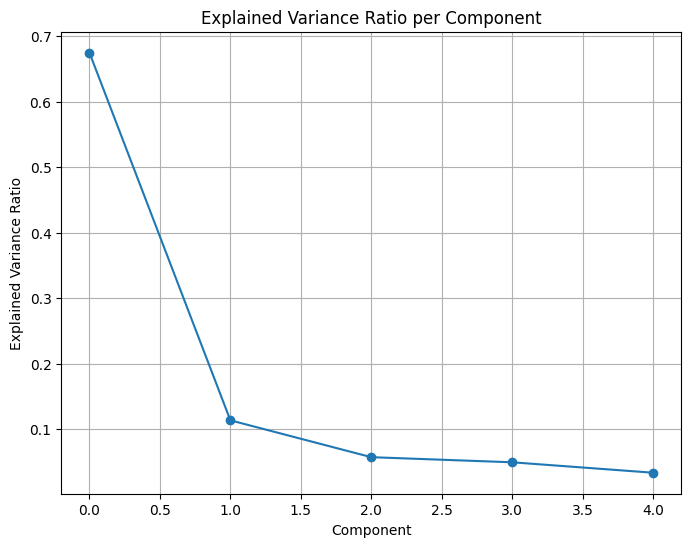

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio per Component')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

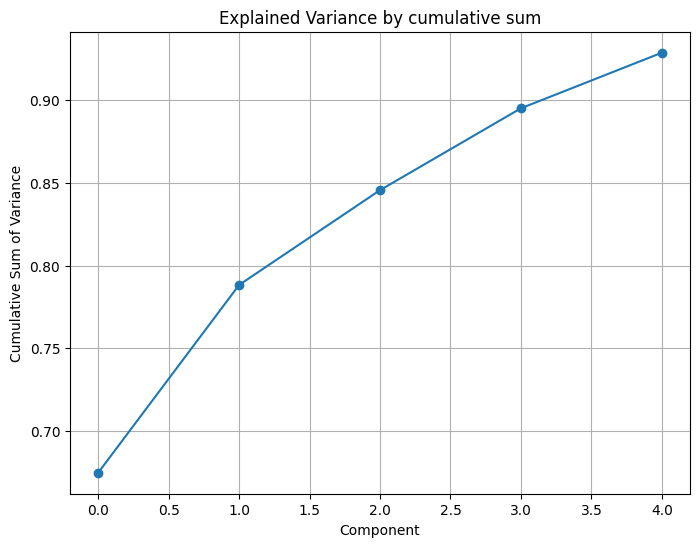

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance by cumulative sum')
plt.xlabel('Component')
plt.ylabel('Cumulative Sum of Variance')
plt.grid(True)
plt.show()

In [ ]:
image_to_celltype_n.head()

celltypes,B,BnT,CD4,CD8,DC,HLADR,MacCD163,Mural,NK,Neutrophil,Treg,Tumor,pDC,plasma
image,,,,,,,,,,,,,,
IMMUcan_2022_WFLOW_10061074-SPECT-VAR-TIS-01-IMC-01_001.tiff,0.003298,0.000000,0.042045,0.181369,0.015664,0.007420,0.124897,0.023495,0.011954,0.110058,0.004122,0.419209,0.010305,0.046167
IMMUcan_2022_WFLOW_10063152-SPECT-VAR-TIS-01-IMC-01_002.tiff,0.003793,0.000000,0.059418,0.035398,0.035398,0.000000,0.107459,0.275601,0.005057,0.007585,0.015171,0.420986,0.021492,0.012642
IMMUcan_2022_WFLOW_10072131-SPECT-VAR-TIS-01-IMC-01_001.tiff,0.117229,0.024867,0.136767,0.277087,0.060391,0.108348,0.060391,0.161634,0.000000,0.001776,0.028419,0.014210,0.007105,0.001776
IMMUcan_2022_WFLOW_10074349-SPECT-VAR-TIS-UNST-03_001.tiff,0.003754,0.007508,0.146879,0.059596,0.080713,0.004223,0.157672,0.076490,0.004693,0.002816,0.007977,0.419521,0.026279,0.001877
IMMUcan_2022_WFLOW_10074350-SPECT-VAR-TIS-UNST-03_004.tiff,0.148080,0.094455,0.124314,0.157831,0.021938,0.000000,0.092626,0.279098,0.006094,0.000000,0.031079,0.001828,0.020719,0.021938


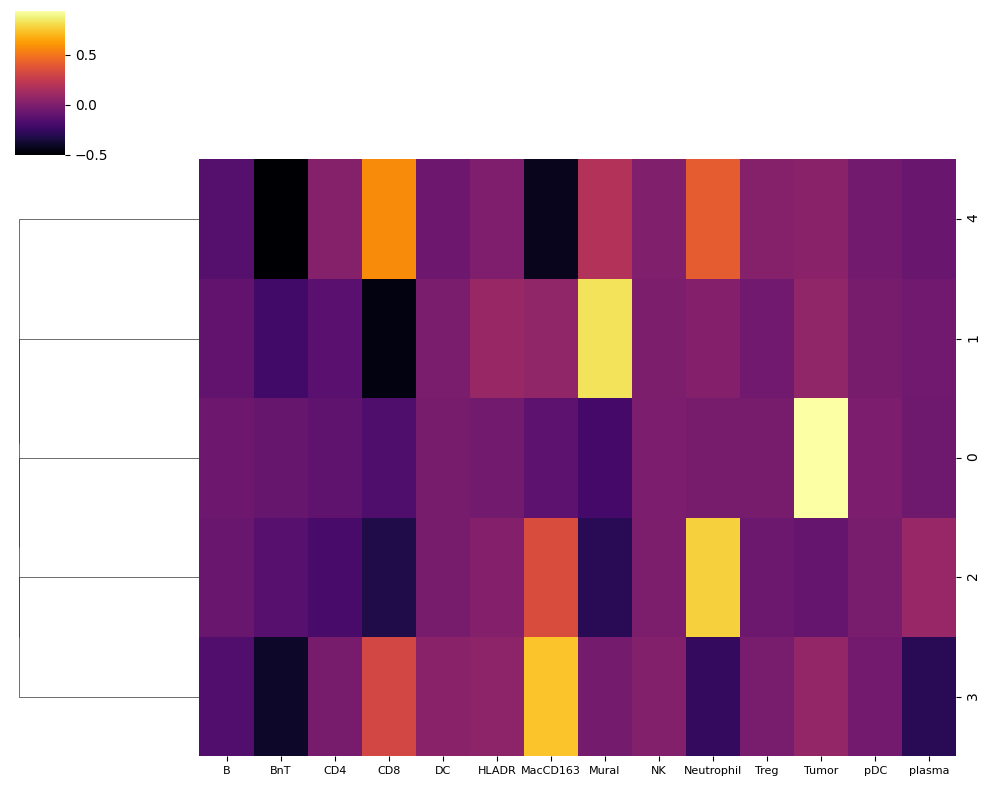

In [ ]:
fig = sns.clustermap(pca.components_, cmap='inferno', figsize=(10, 8), col_cluster=False)
fig.ax_heatmap.set_xticklabels(image_to_celltype_n.columns, fontsize=8)
plt.show()

In the final exercise in this section let's try to provide a first clustering of the data. Your task is to:

- fit [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to the `image_to_celltype_n`,
- visualize clusters centers in a similar fashion as `PCA` components in a previous exercise.

Now repeat the exercise with a Hellinger transform. How the results differ?

You may also try different number of clusters and compare the results.

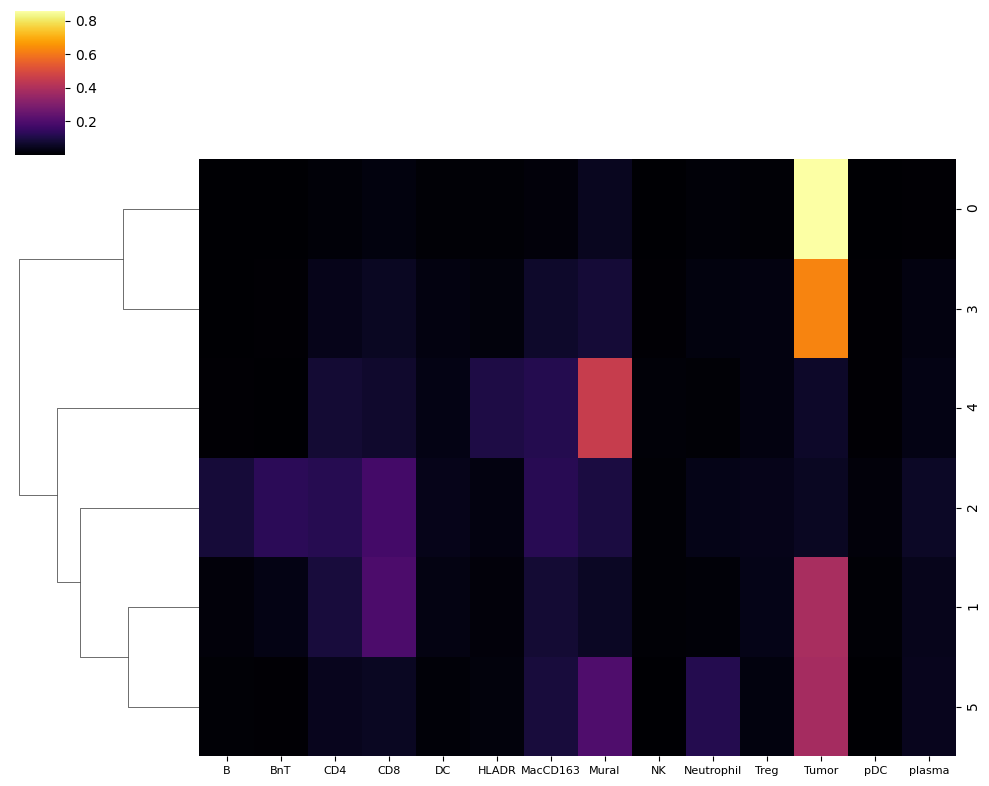

In [ ]:
from sklearn.cluster import KMeans

NB_OF_CLUSTERS = 6
kmeans = KMeans(n_clusters=NB_OF_CLUSTERS, random_state=42, n_init="auto").fit(image_to_celltype_n)

fig = sns.clustermap(kmeans.cluster_centers_, cmap='inferno', figsize=(10, 8), col_cluster=False)
fig.ax_heatmap.set_xticklabels(image_to_celltype_n.columns, fontsize=8)
plt.show()

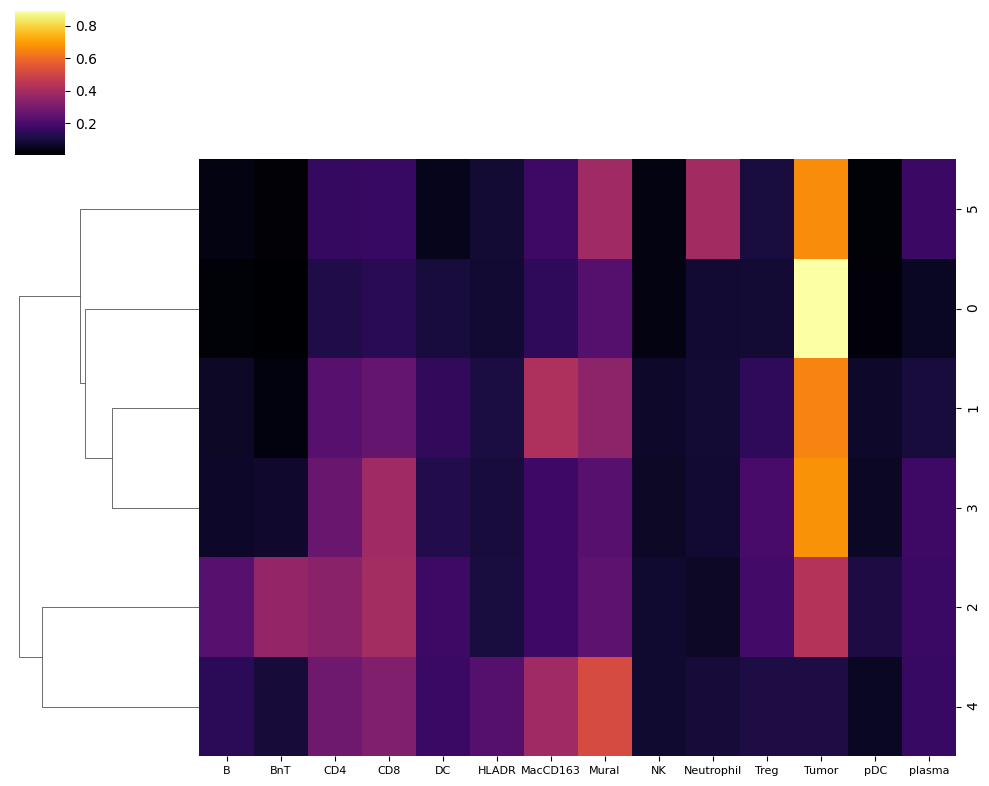

In [ ]:
# Hellinger transform
image_to_celltype_n_h = np.sqrt(image_to_celltype_n)
NB_OF_CLUSTERS = 6
kmeans = KMeans(n_clusters=NB_OF_CLUSTERS, random_state=42, n_init="auto").fit(image_to_celltype_n_h)

fig = sns.clustermap(kmeans.cluster_centers_, cmap='inferno', figsize=(10, 8), col_cluster=False)
fig.ax_heatmap.set_xticklabels(image_to_celltype_n.columns, fontsize=8)
plt.show()

## Squidpy

In this part we will try to use a reowned package for a spatial analysis: [`Squidpy`](https://squidpy.readthedocs.io/en/stable/). Before jumping into the exercise, spend some time reading an introduction and [this](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_imc.html) example.

Before the further steps, let's adjust our `anndata` so it fits the `squidpy` format:

We will also split our main `train_anndata` into single image chunks:

In [ ]:
import pandas as pd

train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values
image_ids = train_anndata.obs['image'].unique()
split_anndatas = {}

for image_id in image_to_celltype_n.index:
  split_anndatas[image_id] = train_anndata[train_anndata.obs['image'] == image_id].copy()

We will also take the `first_anndata_image` as an example to warm up with:

In [ ]:
first_anndata_image = list(split_anndatas.keys())[0]
first_anndata = split_anndatas[first_anndata_image]

In the first task, try to obtain a neighborhood enrichement plot as in the aformentioned [tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_imc.html). Try to print the `first_anndata` after every step you take, and notice how `squidpy` enriches it with the new fields. Try to inrepret an obtained result:

/usr/local/lib/python3.11/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


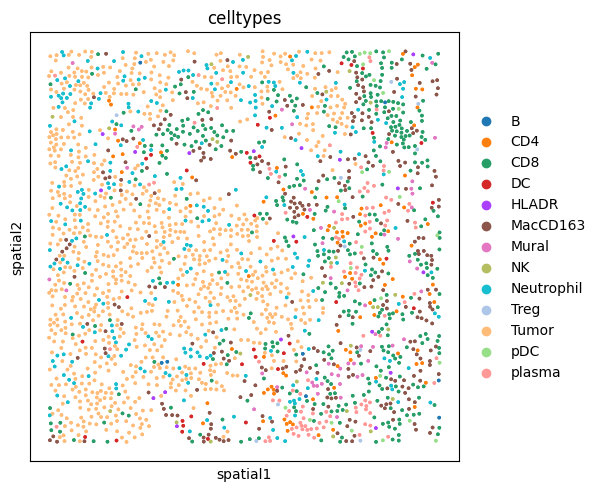

In [ ]:
import squidpy as sq

# Spatial location in the tissue
sq.pl.spatial_scatter(first_anndata, shape=None, color="celltypes", size=10, library_id="spatial")

  0%|          | 0/1 [00:00<?, ?/s]

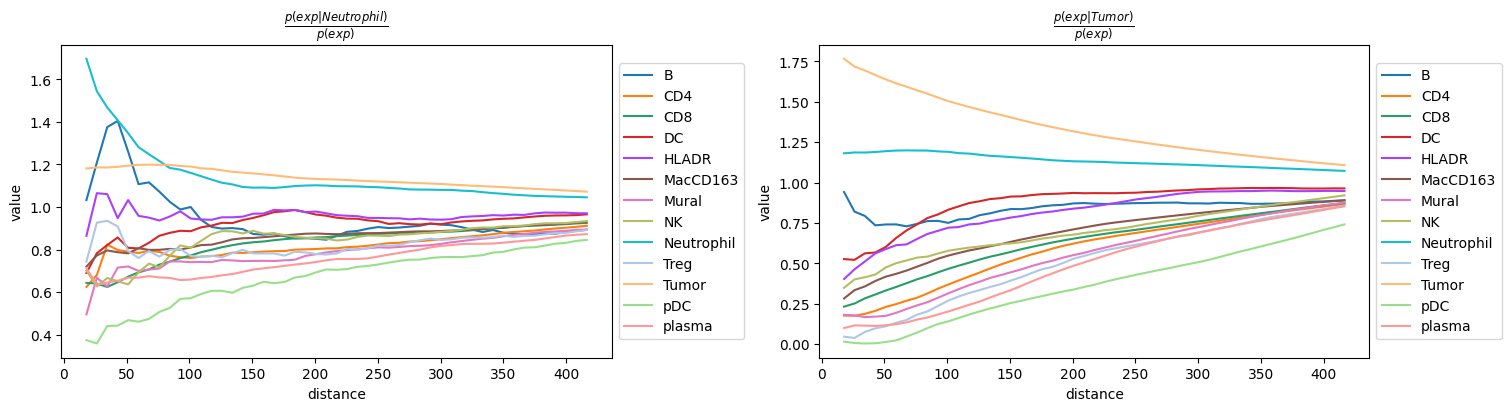

In [ ]:
# Cluster co-occurrence in spatial dimensions (neutrofils with tumors)
sq.gr.co_occurrence(first_anndata, cluster_key="celltypes")
sq.pl.co_occurrence(
    first_anndata,
    cluster_key="celltypes",
    clusters=["Tumor", "Neutrophil"],
    figsize=(15, 4),
)

  0%|          | 0/1000 [00:00<?, ?/s]

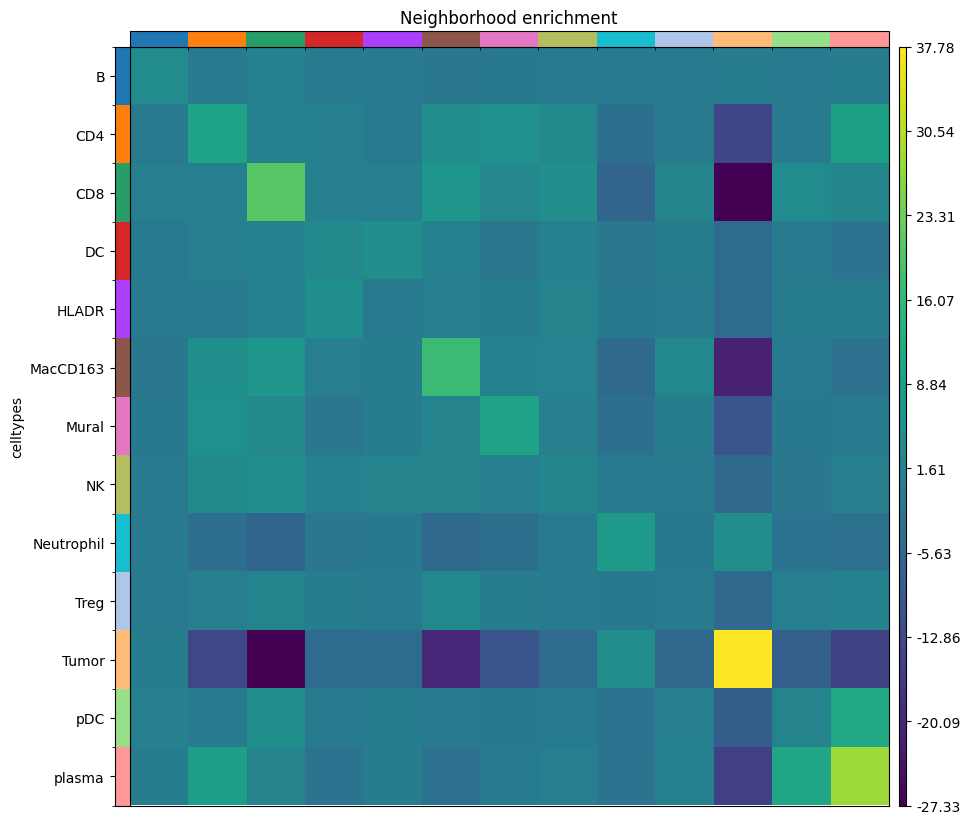

In [ ]:
# neighbor structure of the tissue by clusters
sq.gr.spatial_neighbors(first_anndata, coord_type="grid")
sq.gr.nhood_enrichment(first_anndata, cluster_key="celltypes")
sq.pl.nhood_enrichment(first_anndata, cluster_key="celltypes")

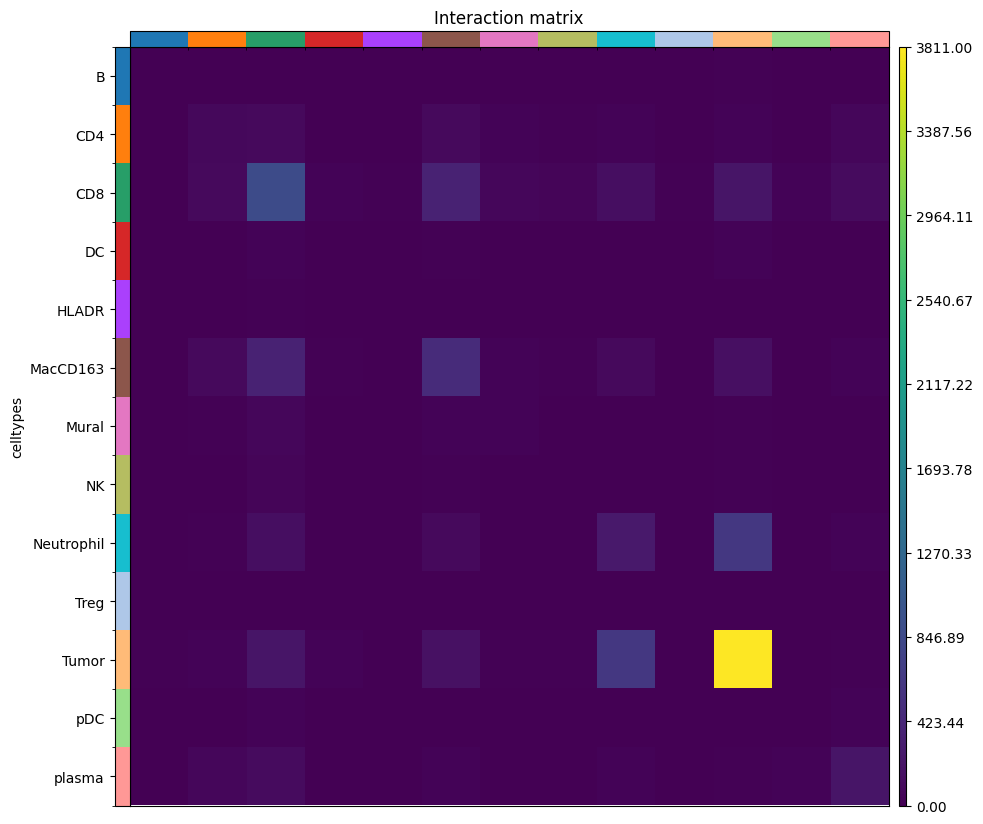

In [ ]:
# Number of edges that each cluster share with all the others
sq.gr.interaction_matrix(first_anndata, cluster_key="celltypes")
sq.pl.interaction_matrix(first_anndata, cluster_key="celltypes")

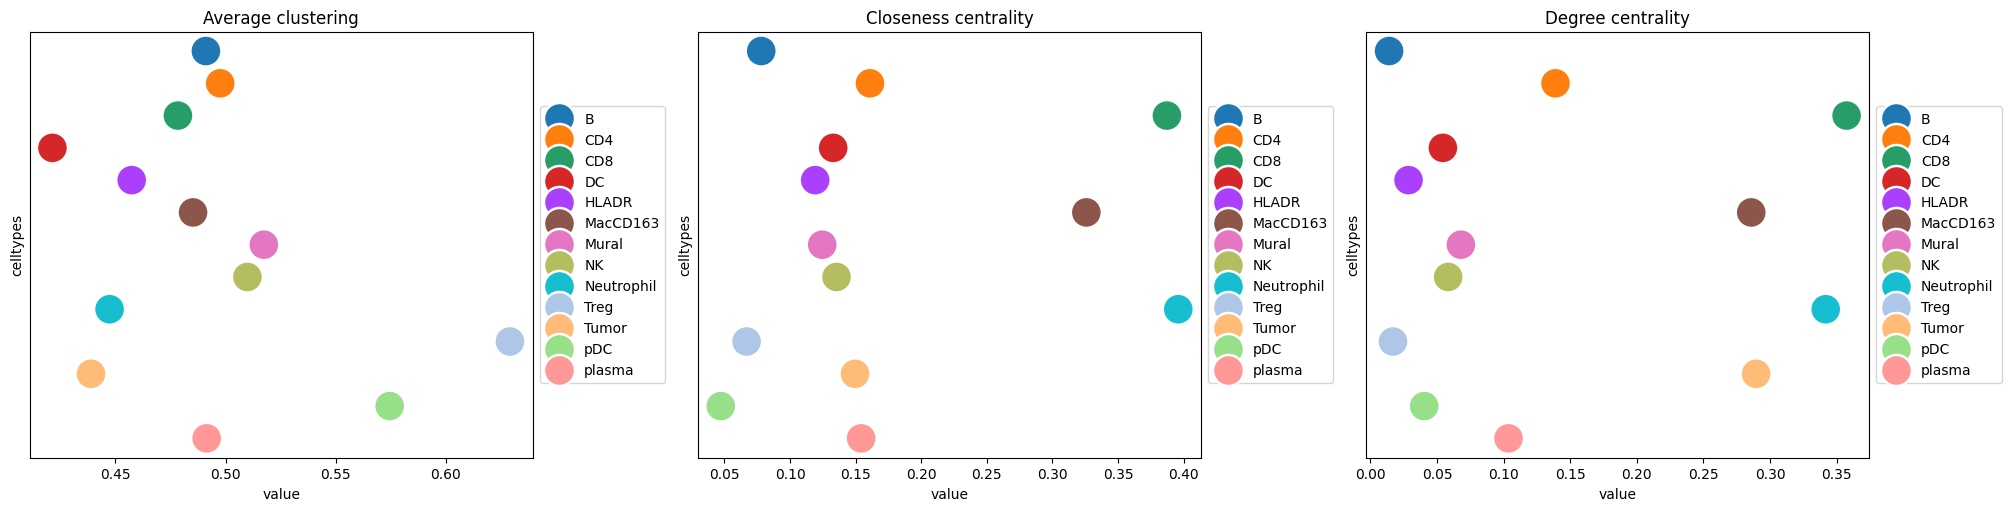

In [ ]:
# Properties of the spatial graph
sq.gr.centrality_scores(
    first_anndata,
    cluster_key="celltypes",
)
sq.pl.centrality_scores(first_anndata, cluster_key="celltypes", figsize=(20, 5), s=500)

Well, unfortunately `squidpy` is not perfect. As you probably noticed, the fields in which the neighborhood data is stored, doesn't contain the information about which cell types each row / column refers to. Because of that let's introduce a handy function that will:
- extend `zscores` of missing celltypes to `0`,
- transform `zscores` using cdf of normal distribution - this will normalize them into a digestible `(0, 1)` interval:

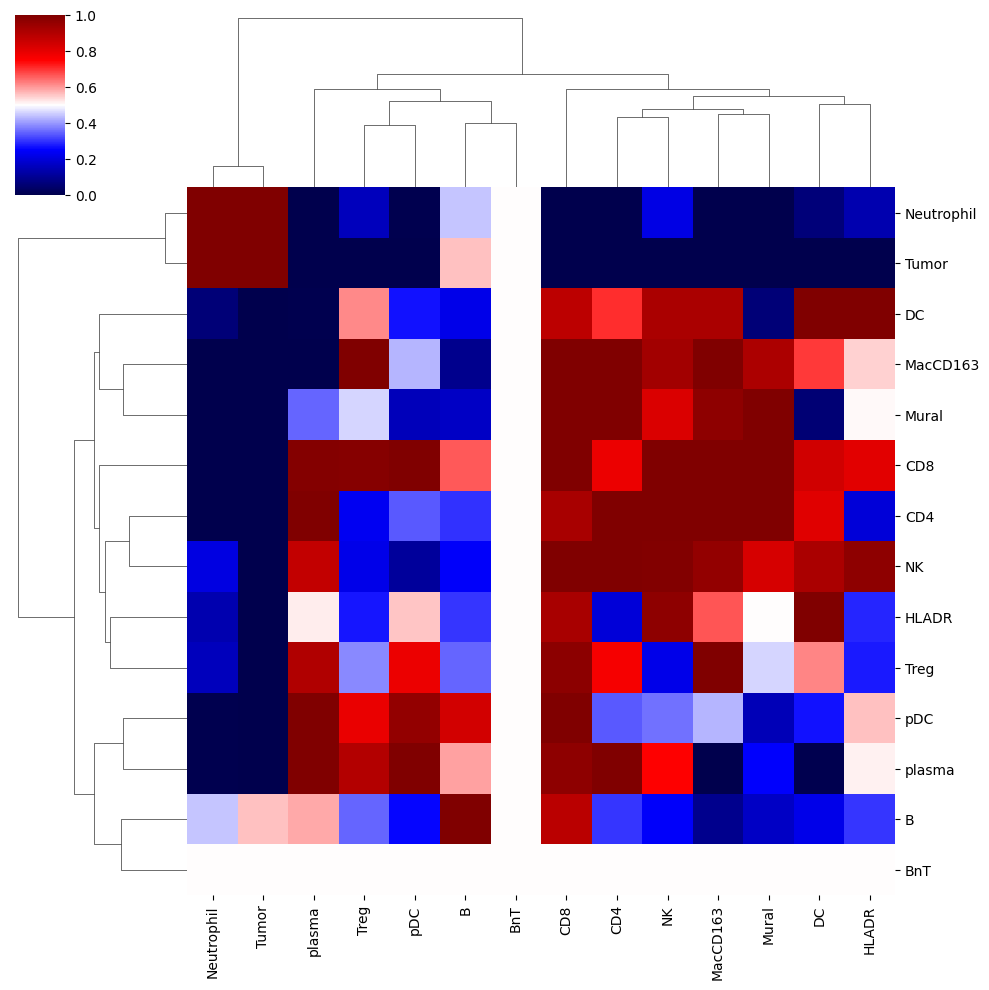

In [ ]:
from scipy.stats import norm as norm_dist


def get_nhood_enrichement_from_anndata(anndata_, celltypes=None):
    if celltypes is None:
        celltypes = sorted(image_to_celltype_n.columns)
    anndata_celltypes = list(anndata_.obs['celltypes'].cat.categories)
    result = np.zeros((len(celltypes), len(celltypes)))
    zscore = anndata_.uns['celltypes_nhood_enrichment']['zscore']
    for l_celltype_ind, l_celltype in enumerate(celltypes):
        if l_celltype not in anndata_celltypes:
            continue
        l_celltype_and_ind = anndata_celltypes.index(l_celltype)
        for r_celltype_ind, r_celltype in enumerate(celltypes):
            if r_celltype not in anndata_celltypes:
                continue
            r_celltype_and_ind = anndata_celltypes.index(r_celltype)
            result[l_celltype_ind, r_celltype_ind] = zscore[l_celltype_and_ind, r_celltype_and_ind]

    result = norm_dist.cdf(result)
    result_df = pd.DataFrame(result, index=celltypes, columns=celltypes)
    return result_df


enrichement = get_nhood_enrichement_from_anndata(first_anndata)
sns.clustermap(enrichement, center=0.5, cmap='seismic')

In the final task in this part you will:
- run the same neighborhood enrichement analysis for all image anndatas from the dataset,
- obtain their standardized version using `get_nhood_enrichement_from_anndata` defined above,
- cluster them into `NB_OF_NHOODS_CLUSTERS`,
- visualize the `KMeans` cluster centers.

Try to interpret the results or ask me or Krzysztof to help.

Good luck!

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

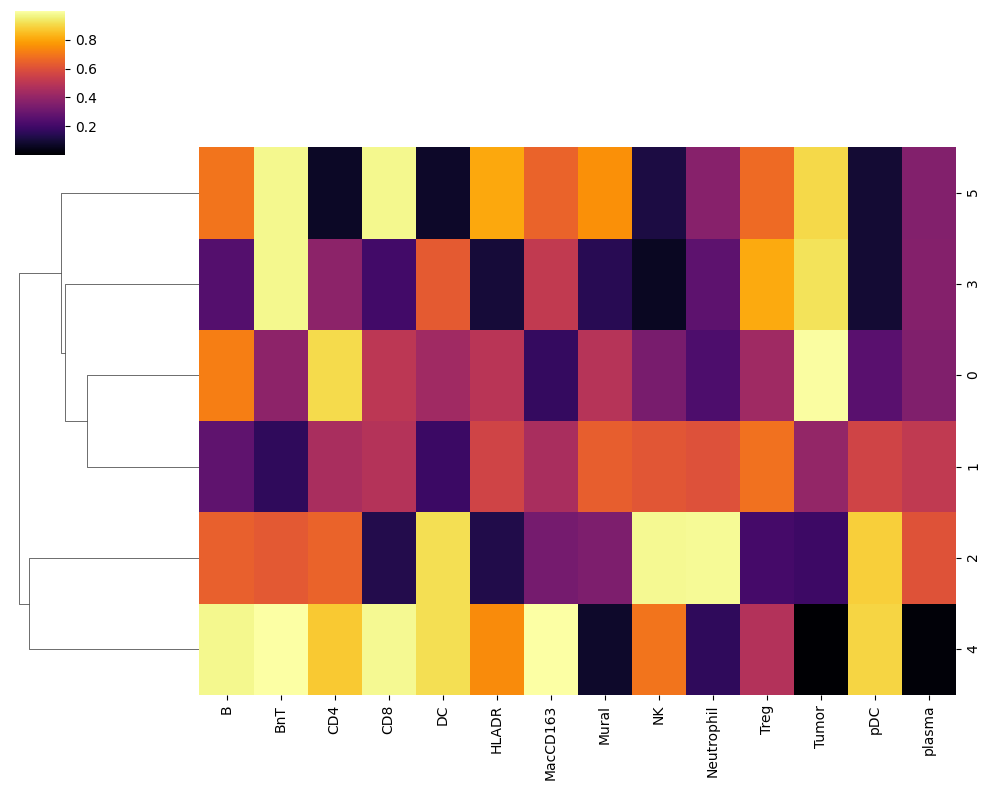

In [ ]:
all_enrichments = []

for image_id, anndata in split_anndatas.items():
    sq.gr.spatial_neighbors(train_anndata, coord_type='grid') # 'generic' with radius
    sq.gr.nhood_enrichment(train_anndata, cluster_key='celltypes')
    enrichment = get_nhood_enrichement_from_anndata(train_anndata)
    all_enrichments.append(enrichment)

# Combine into a single DataFrame
all_enrichments_df = pd.concat(all_enrichments, keys=split_anndatas.keys())

# Cluster the enrichments by KMeans
NB_OF_NHOODS_CLUSTERS = 6
kmeans = KMeans(n_clusters=NB_OF_NHOODS_CLUSTERS, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(all_enrichments_df)

# Visualize cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=all_enrichments_df.columns)
sns.clustermap(cluster_centers, cmap='inferno', figsize=(10, 8), col_cluster=False)
plt.show()

## Next steps

If you finished earlier, you may try:
1. Compare clusterings obtained using basic cell type percentages with the ones using `squidpy`,
2. Try to run the analysis above using different [`spatial_neighbors`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_neighbors.html#squidpy.gr.spatial_neighbors) parameters (e.g., with `radius=25`).

### Next steps *:

Notice that `squidpy` enriched anndatas have a field `anndata.obsp['spatial_connectivities']`. It stores the neighborhood graph for each image. This graph might be useful to our first play with cellular neighborhood, namely:

1. For each cell compute the histogram of cell types of her neighbors,
2. Collect histograms of all cells from all images and run a `PCA` algorithm analysis similar to the one introduced in *Celltype count based representation of images* section.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Comparison of clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels1 = kmeans.fit_predict(all_enrichments_df)

kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
labels2 = kmeans.fit_predict(all_enrichments_df)

ari = adjusted_rand_score(labels1, labels2)
nmi = normalized_mutual_info_score(labels1, labels2)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.434476423759951
Normalized Mutual Information: 0.6945391475901742


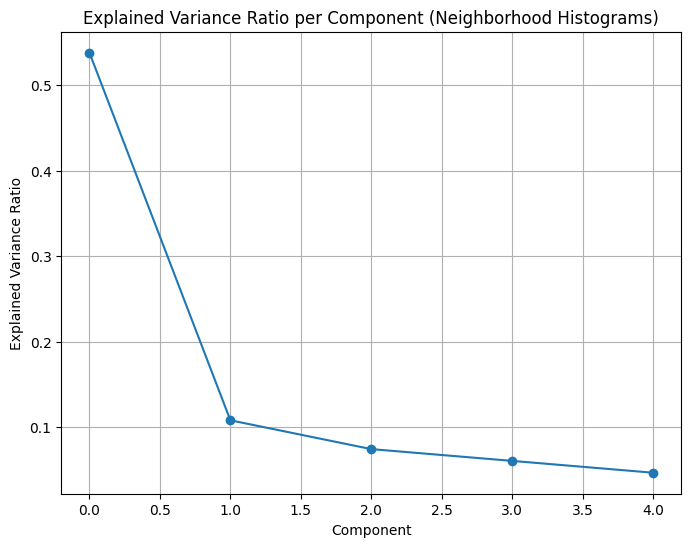

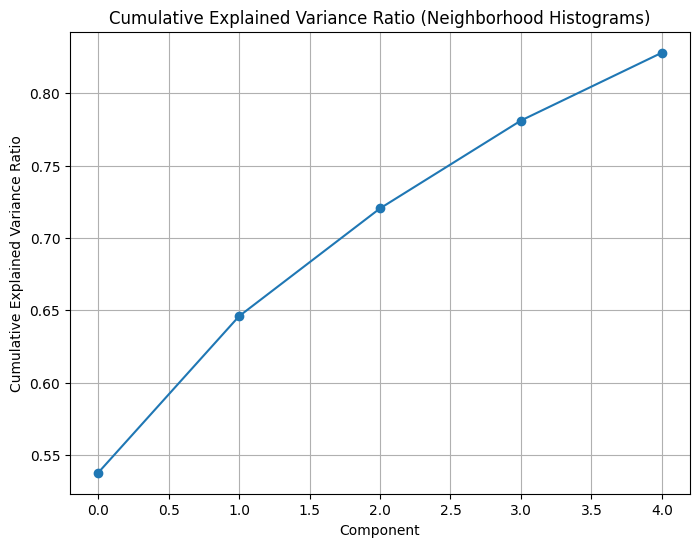

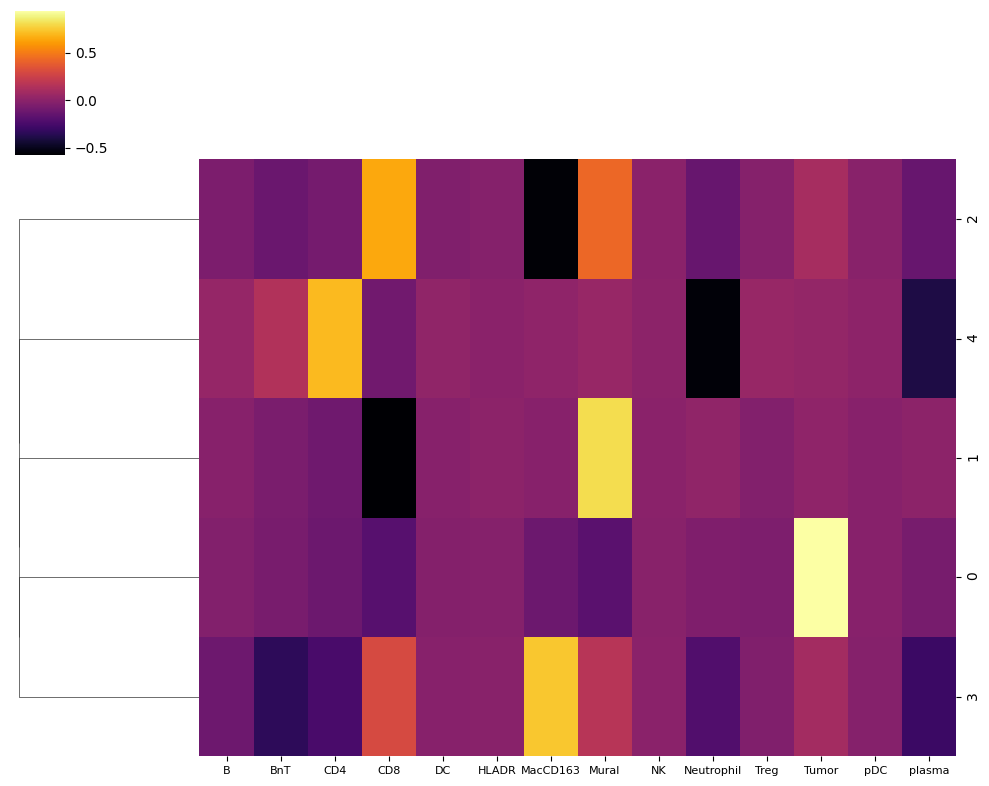

In [ ]:
all_histograms = []
all_celltypes = train_anndata.obs['celltypes'].cat.categories

for image_id, anndata in split_anndatas.items():
    sq.gr.spatial_neighbors(anndata, coord_type='grid')
    connectivities = anndata.obsp['spatial_connectivities']

    for i in range(anndata.n_obs):
        neighbors = connectivities[i].nonzero()[1]
        neighbor_celltypes = anndata.obs['celltypes'].iloc[neighbors].values

        histogram = np.zeros(len(all_celltypes))
        for celltype in neighbor_celltypes:
            idx = np.where(all_celltypes == celltype)[0][0]
            histogram[idx] += 1

        all_histograms.append(histogram)

# Create a dataframe from the histograms and normalize
selected_histograms = [
    {celltype: hist[i] for i, celltype in enumerate(all_celltypes)}
    for hist in all_histograms
]
hist_df = pd.DataFrame(selected_histograms, columns=all_celltypes)
hist_df_n = hist_df.div(hist_df.sum(axis=1), axis=0)
hist_df_n = hist_df_n.dropna()

# Apply PCA:
NB_OF_COMPONENTS = 5
pca = PCA(n_components=NB_OF_COMPONENTS)
pca.fit(hist_df_n)

# Visualize explained variance ratio:
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio per Component (Neighborhood Histograms)')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Visualize cumulative variance ratio:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance Ratio (Neighborhood Histograms)')
plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Visualize components using clustermap:
fig = sns.clustermap(pca.components_, cmap='inferno', figsize=(10, 8), col_cluster=False)
fig.ax_heatmap.set_xticklabels(hist_df_n.columns, fontsize=8)
plt.show()